# Text Classification

In [2]:
import itertools
import re

In [3]:
from dataset import news20
from nn.layer import *
from optim.optimizer import *
from util.common import *
from util.common import Sample

In [4]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import pandas as pd
from wordcloud import WordCloud
import random as rd

In [5]:
initEngine(1,4)

## 1. Define some utility functions
* break the text corpus into tokens (words)

In [6]:
def text_to_words(review_text):
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    words = letters_only.lower().split()
    return words

* calcualte the frequency of words in each text corpus, sort by frequency, and assign an id to each word

In [7]:
def analyze_texts(data_rdd):
    return data_rdd.flatMap(lambda (text, label): text_to_words(text)) \
        .map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b) \
        .sortBy(lambda (w, c): - c).zipWithIndex() \
        .map(lambda ((w, c), i): (w, (i + 1, c))).collect()

* pad the embedding to required length

In [8]:
# pad([1, 2, 3, 4, 5], 0, 6)
def pad(l, fill_value, width):
    if len(l) >= width:
        return l[0: width]
    else:
        l.extend([fill_value] * (width - len(l)))
        return l

* word to vec

In [9]:
def to_vec(token, b_w2v, embedding_dim):
    if token in b_w2v:
        return b_w2v[token]
    else:
        return pad([], 0, embedding_dim)

* assemble the features (embeddings of words in each text sample) and label into samples

In [10]:
def to_sample(vectors, label, embedding_dim,sequence_len):
    # flatten nested list
    flatten_features = list(itertools.chain(*vectors))
    features = np.array(flatten_features, dtype='float').reshape(
        [sequence_len, embedding_dim]).transpose(1, 0)
    return Sample.from_ndarray(features, np.array(label))

## 2. Training the model

* set some tunable parameters

In [11]:
batch_size = 128
embedding_dim = 50
sequence_len = 50
max_words = 1000 
training_split = 0.8

* prepare samples

In [12]:
def prepare_samples(texts,
                    sequence_len=sequence_len,
                    max_words=max_words,
                    embedding_dim=embedding_dim):
    print "preparing samples with embedding_dim = %s, sequence_len=%s"%(embedding_dim,sequence_len)
    #analyze input texts
    data_rdd = sc.parallelize(texts, 2)
    word_to_ic = analyze_texts(data_rdd)
    # take the top "max_words" most frequent words while remove the top 10 ( may not be meaningful,e.g. "of","the")
    word_to_ic = dict(word_to_ic[10: max_words])
    bword_to_ic = sc.broadcast(word_to_ic)
    
    #prepare embeddings
    w2v = news20.get_glove_w2v(dim=embedding_dim)
    filtered_w2v = {w: v for w, v in w2v.items() if w in word_to_ic}
    bfiltered_w2v = sc.broadcast(filtered_w2v)

    tokens_rdd = data_rdd.map(lambda (text, label):
                              ([w for w in text_to_words(text) if
                                w in bword_to_ic.value], label))
    padded_tokens_rdd = tokens_rdd.map(
        lambda (tokens, label): (pad(tokens, "##", sequence_len), label))

    vector_rdd = padded_tokens_rdd.map(lambda (tokens, label):
                                       ([to_vec(w, bfiltered_w2v.value,
                                                embedding_dim) for w in
                                         tokens], label))
    sample_rdd = vector_rdd.map(
        lambda (vectors, label): to_sample(vectors, label, embedding_dim,sequence_len))
    print('Generated Samples')
    return sample_rdd

In [13]:
texts = news20.get_news20()
sample_rdd = prepare_samples(texts)

('Downloading data from', 'http://qwone.com/~jason/20Newsgroups/20news-19997.tar.gz')
17334272/17332201 [==============================] - 63s      

* pick a random text and draw a word cloud to gain some sense into what the new sample is about. 

In [14]:
rand_idx=rd.randrange(0, len(texts))
wordcloud = WordCloud(max_font_size=40,background_color="white").generate(texts[rand_idx][0])

(-0.5, 399.5, 199.5, -0.5)

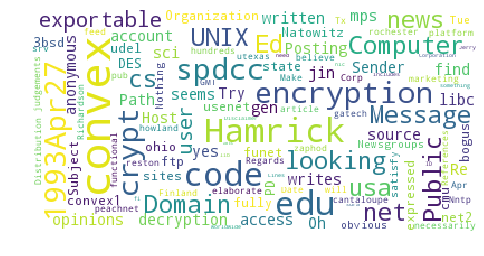

In [15]:
plt.imshow(wordcloud)
plt.axis("off")

* split the samples into train and validation set 

In [16]:
#split train val sets
train_rdd, val_rdd = sample_rdd.randomSplit([training_split, 1-training_split])

* build the model

In [17]:
def build_model(class_num=news20.CLASS_NUM,
                embedding_dim=embedding_dim,
                sequence_len=sequence_len):
    print "building model with embedding_dim = %s, sequence_len=%s"%(embedding_dim,sequence_len)
    model = Sequential()
    model.add(Reshape([embedding_dim, 1, sequence_len]))
    model.add(SpatialConvolution(embedding_dim, 128, 5, 1))
    model.add(ReLU())
    model.add(SpatialMaxPooling(5, 1, 5, 1))
    model.add(SpatialConvolution(128, 128, 5, 1))
    model.add(ReLU())
    model.add(SpatialMaxPooling(5, 1, 5, 1))
    model.add(Reshape([128]))
    model.add(Linear(128, 100))
    model.add(Linear(100, class_num))
    model.add(LogSoftMax())
    return model

* configure optimizer

In [18]:
#configure optimizer
def config_optimizer(model,
                     batch_size=batch_size,
                     lr=0.01,
                     lrd=0.0002,
                     optim="Adagrad",
                     val=["top1"],
                     max_epoch=2):
    
    state = {"batchSize": batch_size,
         "learningRate": lr,
         "learningRateDecay": lrd}
    #configure optimizer
    optimizer = Optimizer(
        model=model,
        training_rdd=train_rdd,
        criterion=ClassNLLCriterion(),
        end_trigger=MaxEpoch(max_epoch),
        batch_size=batch_size,
        optim_method=optim,
        state=state)

    optimizer.setvalidation(
        batch_size=batch_size,
        val_rdd=val_rdd,
        trigger=EveryEpoch(),
        val_method=val
    )
    return optimizer

In [19]:
%%time
model = build_model()
optimizer = config_optimizer(model)

building model with embedding_dim = 50, sequence_len=50
creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createReshape
creating: createLinear
creating: createLinear
creating: createLogSoftMax
creating: createClassNLLCriterion
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
CPU times: user 31.9 ms, sys: 10.2 ms, total: 42 ms
Wall time: 22.6 s


* Train the network. Wait some time till it finished.. Voila! You've got a trained model

In [20]:
%%time
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 2.55 ms, sys: 1.64 ms, total: 4.19 ms
Wall time: 22 s


## 3. Examine the prediction results

* Let's look closely on the predicted results of validation set

In [21]:
predictions = trained_model.predict(val_rdd)

In [22]:
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l[0] - 1

In [23]:
y_pred = np.array([ map_predict_label(s.label) for s in predictions.collect()])

In [24]:
y_true = np.array([map_groundtruth_label(s.label) for s in val_rdd.collect()])

* compute the confustion matrix and plot it

In [25]:
cm = confusion_matrix(y_true, y_pred)
cm.shape

(20, 20)

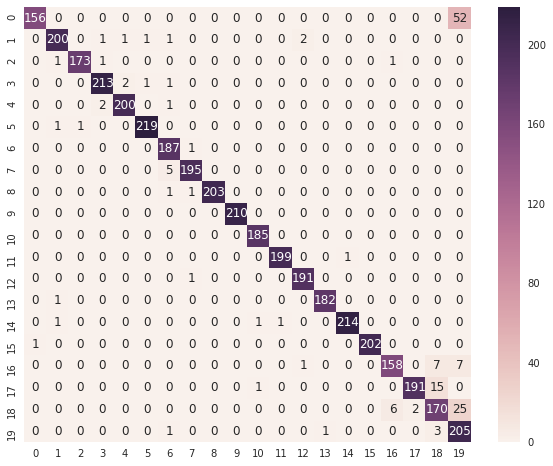

In [26]:
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d')

## 4 Change optimzation methods

* create a new optimizer and use SGD as optim_method, train a new model and make predictions. The confusion matrix shows the result is much worse than Adagrad after 2 epochs. SGD needs much longer to converge than Adagrad. 

In [25]:
%%time
#need to build a new model, because after optimization, the input model is modified *in-place*. 
#use model without building a new one equals to resume training based on the trained model in the previous step
model = build_model()
optimizer = config_optimizer(model,optim="SGD")

building model with embedding_dim = 50, sequence_len=50
creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createReshape
creating: createLinear
creating: createLinear
creating: createLogSoftMax
creating: createClassNLLCriterion
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
CPU times: user 29.3 ms, sys: 11.2 ms, total: 40.5 ms
Wall time: 21.7 s


In [26]:
%%time
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 2.5 ms, sys: 1.76 ms, total: 4.26 ms
Wall time: 21.5 s


In [27]:
predictions = trained_model.predict(val_rdd)
y_pred2 = np.array([ map_predict_label(s.label) for s in predictions.collect()])

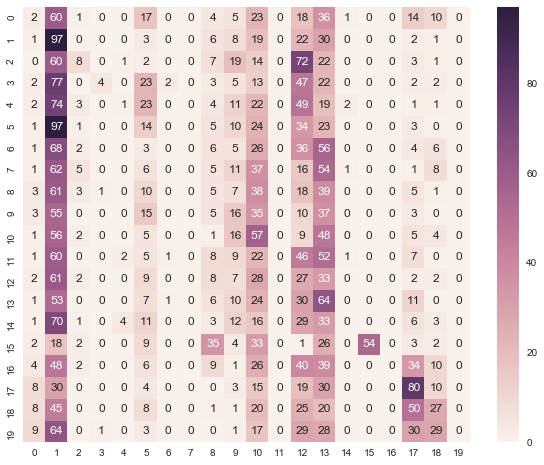

In [28]:
plt.figure(figsize = (10,8))
sn.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred2)), annot=True,fmt='d')

## 5. Change the size of embeddings

* use double size embedding_dim makes no significant improvement in the precision of predictions

In [29]:
embedding_dim = 100
sequence_len = 50

In [30]:
sample_rdd = prepare_samples(texts,embedding_dim=embedding_dim)
#split train val sets
train_rdd, val_rdd = sample_rdd.randomSplit([training_split, 1-training_split])

preparing samples with embedding_dim = 100, sequence_len=50
Generated Samples


In [31]:
%%time
model = build_model(embedding_dim=embedding_dim)
optimizer = config_optimizer(model,optim="Adagrad")
trained_model = optimizer.optimize()
print "Optimization Done."

building model with embedding_dim = 100, sequence_len=50
creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createReshape
creating: createLinear
creating: createLinear
creating: createLogSoftMax
creating: createClassNLLCriterion
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
Optimization Done.
CPU times: user 44.2 ms, sys: 13.8 ms, total: 58.1 ms
Wall time: 55.9 s


In [32]:
predictions = trained_model.predict(val_rdd)
y_true = np.array([map_groundtruth_label(s.label) for s in val_rdd.collect()])
y_pred3 = np.array([ map_predict_label(s.label) for s in predictions.collect()])

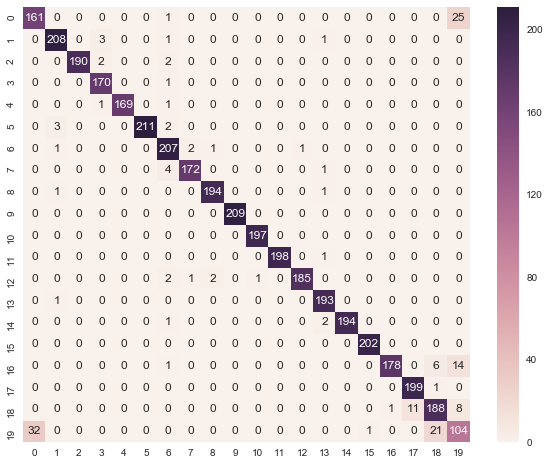

In [33]:
plt.figure(figsize = (10,8))
sn.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred3)), annot=True,fmt='d')